In [188]:
# definitions for pre-processing data
import pandas as pd
import datetime 
import numpy as np
import math

def convert_time(string_time):
    # given a time in string format, output a time in datetime.time format
    format = "%H:%M:%S"
    output = datetime.datetime.strptime(string_time, format)
    return output.time()

def convert_date(string_date):
    # given a date in string format, output a time in datetime.date format
    format = "%m/%d/%Y"
    output = datetime.datetime.strptime(string_date, format)
    return output.date()

def calculate_volatility(df):
    # given a df for a time period, calculate the VWAP for this time period
    volume_total = df["Volume"].sum()
    if volume_total == 0:
        return 0
    volume_times_price_total = (df["Volume"] * df["Price"]).sum()
    vwap = volume_times_price_total / volume_total
    last_valid_index = df["Price"].last_valid_index()
    final_price = df["Price"][last_valid_index]
    volatility = abs(final_price - vwap)
    volatility = volatility / final_price * 100
    return volatility

def gen_features_and_targets_GRU(df):
    grouped_by_date = df.groupby(df['Date'])
    features = np.zeros((len(grouped_by_date), 1, 29))
    targets = np.zeros((len(grouped_by_date), 1))
    date_counter = 0
    for date in grouped_by_date.groups.keys():
        cur_df = grouped_by_date.get_group(date)
        cur_grouped = cur_df.groupby(cur_df["Minute"])
        for minute in range(30, 60):
            try:
                cur_minute = cur_grouped.get_group(minute)
            except:
                if minute == 59:
                    targets[date_counter][0] = 0
                else:
                    features[date_counter][0][minute-30] = 0
                continue
            volatility = calculate_volatility(cur_minute)
            if minute == 59:
                targets[date_counter][0] = volatility
            else:
                features[date_counter][0][minute-30] = volatility
        date_counter += 1
    return np.array(features), np.array(targets)

def gen_features_and_targets_base(df):
    grouped_by_date = df.groupby(df['Date'])
    features = []
    targets = []
    for date in grouped_by_date.groups.keys():
        cur_df = grouped_by_date.get_group(date)
        cur_grouped = cur_df.groupby(cur_df["Minute"])
        cur_features = []
        for minute in range(30, 60):
            try:
                cur_minute = cur_grouped.get_group(minute)
            except:
                if minute == 59:
                    targets.append(0)
                else:
                    cur_features.append(0)
                continue
            volatility = calculate_volatility(cur_minute)
            if minute == 59:
                targets.append(volatility)
            else:
                cur_features.append(volatility)
        features.append(cur_features)
    return np.array(features), np.array(targets)

def load_data(path, type="base"):
    df = pd.read_csv(path)
    df['Time'] = df['Time'].apply(lambda x: convert_time(x))
    df = df.loc[(df['Time'] >= datetime.time(15, 30, 0)) & (df["Time"] < datetime.time(16, 0, 0))]
    df['Date'] = df['Date'].apply(lambda x: convert_date(x))
    df['Minute'] = df['Time'].apply(lambda x: x.minute)
    if type == "GRU":
        features, targets = gen_features_and_targets_GRU(df)
    else:
        features, targets = gen_features_and_targets_base(df)
    return features, targets



In [190]:
# features, targets = load_data("IVE_tickbidask.txt")
features, targets = load_data("2019.txt")

In [204]:
# definitions for the base model
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
%matplotlib inline

activation_relu = torch.nn.ReLU()
Loss_Function = torch.nn.MSELoss()
Learning_Rate = 0.001
epochs = 1000


class BaseModule(torch.nn.Module):
    def __init__(self):
        super(BaseModule, self).__init__()
        self.layer_1 = torch.nn.Linear(29, 10)
        self.layer_2 = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.layer_1(x)
        x = activation_relu(x)
        x = self.layer_2(x)
        return x
    
    
def train_model(dataset, model, epochs):
    optimizer = optim.SGD(model.parameters(), lr=Learning_Rate)
    epoch_list = []
    loss_list = []
    for epoch in tqdm(range(epochs)):
        avg_loss = 0
        for data in dataset:
            x, y = data
            optimizer.zero_grad()
            output = model(x.float())
            y = torch.Tensor([y])
            #print("Output = {}".format(output))
            #print("y = {}".format(y))
            loss = Loss_Function(output, y)
            avg_loss += loss
            loss.backward()
            optimizer.step()
        epoch_list.append(epoch+1)
        loss_list.append(avg_loss/len(dataset))
    return epoch_list, loss_list
            
def test_model(dataset, model):
    estimation = []
    ground_truth = []
    for x, label in dataset:
        out = model(x.float())
        estimation.append(out.item())
        ground_truth.append(label.item())
    sMAPE = 0
    for i in range(len(estimation)):
        sMAPE += np.mean(abs(estimation[i]-ground_truth[i])/(ground_truth[i]+estimation[i])/2)/len(estimation)
    return sMAPE

def draw_result(epoch_list, loss_list):
    fix, ax = plt.subplots()
    line_1 = ax.plot(epoch_list, loss_list, label="training_loss")
    ax.set(xlabel="epoch", ylabel="loss")
    ax.legend()
    plt.show()

In [205]:
base_model = BaseModule()

numOfTest = int(features.shape[0]/10)
numOfTrain = features.shape[0] - numOfTest
tensor_features = torch.from_numpy(features)
tensor_targets = torch.from_numpy(targets)
my_dataset = TensorDataset(tensor_features, tensor_targets)
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [numOfTrain, numOfTest])



100%|██████████| 1000/1000 [00:49<00:00, 20.07it/s]


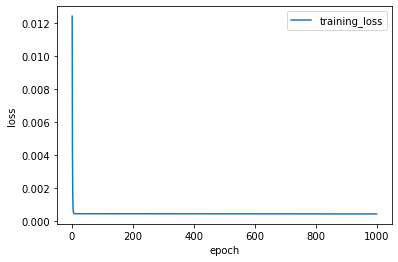

0.17988006967537087


In [206]:
training_epoch_list, training_loss_list = train_model(train_dataset, base_model, epochs)
draw_result(training_epoch_list, training_loss_list)
print(test_model(test_dataset, base_model))

In [ ]:
features, targets = load_data("2019.txt")

In [44]:
net = BaseModule()
optimizer = optim.SGD(net.parameters(), lr=Learning_Rate)

In [45]:
tensor_features = torch.Tensor(features)
tensor_targets = torch.Tensor(targets)
my_dataset = TensorDataset(tensor_features, tensor_targets)
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [200, 49])

100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]


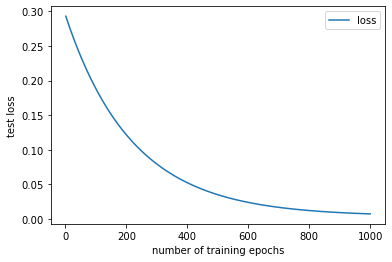

In [46]:
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
%matplotlib inline

epoch = 1000

fix, ax = plt.subplots()
x = []
y = []
current = 0
for i in tqdm(range(epoch)):
    current += 1
    x.append(current)
    y.append(math.sqrt(step_train_model(train_dataset, test_dataset, net)))
x = np.array(x)
y= np.array(y)


line_1 = ax.plot(x, y, label="loss")
ax.set(xlabel="number of training epochs", ylabel="test loss")
ax.legend()
plt.show()

In [133]:
# definitions for the GNU model
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_printoptions(precision=10)
activation_relu = torch.nn.ReLU()


class GRUNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, numOfLayers, dropout_threshold=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.numOfLayers = numOfLayers
        self.gru_layer = torch.nn.GRU(input_dim, hidden_dim, numOfLayers, batch_first=True, dropout=dropout_threshold)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h):
        out, hn = self.gru_layer(x, h)
        out = self.fc(activation_relu(out[:, -1]))
        return out, hn
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.numOfLayers, batch_size, self.hidden_dim).zero_()
        return hidden
    

In [157]:
features, targets = load_data("2019.txt", type="GRU")
# features, targets = main_load_data("IVE_tickbidask.txt")

In [179]:
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

input_dim = 29
output_dim = 1
hidden_dim = 128
numOfLayers = 2
Loss_Function = torch.nn.MSELoss()
learning_rate = 0.001
numOfEpoch = 1000
batch_size = 10

model = GRUNet(input_dim, hidden_dim, output_dim, numOfLayers)
numOfTest = int(features.shape[0]/10)
numOfTrain = features.shape[0] - numOfTest
tensor_features = torch.from_numpy(features)
tensor_targets = torch.from_numpy(targets)
my_dataset = TensorDataset(tensor_features, tensor_targets)
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [numOfTrain, numOfTest])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = batch_size, drop_last=True)
test_loader = DataLoader(test_dataset)

def train_model():
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    epoch_list = []
    loss_list = []
    counter = 1
    for epoch in tqdm(range(1, numOfEpoch+1)):
        h = model.init_hidden(batch_size)
        for x, label in train_loader:
            avg_loss = 0
            h = h.data
            model.zero_grad()
#             print(x.float())
            out, h = model(x.float(), h)
#             print(out)
#             print(h)
            loss = Loss_Function(out, label.float())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
#             print(loss)
            avg_loss += loss.item()
        epoch_list.append(counter)
#         print(avg_loss)
        loss_list.append(avg_loss/len(train_loader))
        counter += 1
    return epoch_list, loss_list

def evaluate_model():
    estimation = []
    ground_truth = []
    for x, label in test_loader:
        w = next(model.parameters()).data
        h = w.new(numOfLayers, x.shape[0], hidden_dim).zero_()
        h = h.data
        out, h = model(x.float(), h)
        estimation.append(out.item())
        ground_truth.append(label.item())
#     print(estimation)
#     print(ground_truth)
    sMAPE = 0
    for i in range(len(estimation)):
        sMAPE += np.mean(abs(estimation[i]-ground_truth[i])/(ground_truth[i]+estimation[i])/2)/len(estimation)
    return sMAPE
           
        
def draw_result(epoch_list, loss_list):
    fix, ax = plt.subplots()
    line_1 = ax.plot(epoch_list, loss_list, label="training_loss")
    ax.set(xlabel="epoch", ylabel="loss")
    ax.legend()
    plt.show()

In [186]:
int(features.shape[0]/10)

25

In [180]:
training_epoch_list, training_loss_list = train_model()


100%|██████████| 1000/1000 [01:15<00:00, 13.27it/s]


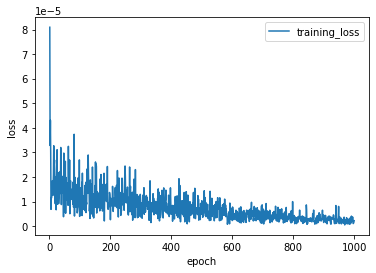

In [182]:
draw_result(training_epoch_list, training_loss_list)

In [181]:
evaluate_model()

0.20271258840352588

In [183]:
model.eval()

GRUNet(
  (gru_layer): GRU(29, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)